In [1]:
!pip install keras-tuner
!pip install -qqq tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.0 MB/s eta 0:00:00


In [2]:
import os
import random

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import tensorflow as tf
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
import keras_tuner
import tensorflow_io as tfio

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [3]:
# Splitting the dataset into training and testing splits
train_list_1 = tf.io.gfile.glob("/content/drive/MyDrive/Train_mel/real/*.npy")
print(f"Number of audio files: {len(train_list_1)}")

train_list_2 = tf.io.gfile.glob("/content/drive/MyDrive/Train_mel/gen/*.npy")
print(f"Number of audio files: {len(train_list_2)}")

test_list_1 = tf.io.gfile.glob("/content/drive/MyDrive/Test_mel/real/*.npy")
print(f"Number of audio files: {len(test_list_1)}")

test_list_2 = tf.io.gfile.glob("/content/drive/MyDrive/Test_mel/gen/*.npy")
print(f"Number of audio files: {len(test_list_2)}")

train_list = train_list_1 + train_list_2
random.shuffle(train_list)
valid_list = train_list[:400]
train_list = train_list[400:]
test_list = test_list_1 + test_list_2
print(f"Number of training files : {len(train_list)}")
print(f"Number of validation files : {len(valid_list)}")
print(f"Number of testing files : {len(test_list)}")

Number of audio files: 1530
Number of audio files: 1530
Number of audio files: 512
Number of audio files: 512
Number of training files : 2660
Number of validation files : 400
Number of testing files : 1024


In [42]:
learning_rate = 1e-6
weight_decay = 1e-5
batch_size = 16
num_epochs = 50


In [46]:
import tensorflow as tf
import numpy as np

# Load label mapping
label_mapping = {'01': 1, '02': 2, '03': 3, '04': 4, '05': 5}

def load_data_with_label(filename):
    data = np.load(filename)
    path_parts = filename.split('/')
    filename_part = path_parts[-1]
    filename_parts = filename_part.split('_')
    cls = filename_parts[1]
    label = label_mapping.get(cls, 0)
    return data, label

# Define the number of classes
num_classes = len(label_mapping)

# Load and preprocess the training dataset
train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: ((load_data_with_label(file_path)) for file_path in train_list),
    output_signature=(tf.TensorSpec(shape=(128, 52), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
)

# One-hot encode the labels for training data
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load and preprocess the validation dataset
valid_dataset = tf.data.Dataset.from_generator(
    generator=lambda: ((load_data_with_label(file_path)) for file_path in valid_list),
    output_signature=(tf.TensorSpec(shape=(128, 52), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
)

# One-hot encode the labels for validation data
valid_dataset = valid_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load and preprocess the test dataset
test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: ((load_data_with_label(file_path)) for file_path in test_list),
    output_signature=(tf.TensorSpec(shape=(128, 52), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
)

# One-hot encode the labels for test data
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

test_dataset = test_dataset.batch(1).prefetch(tf.data.AUTOTUNE)


In [6]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 52), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [7]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 52), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [8]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 52), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [9]:
class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        images = tf.expand_dims(images,axis=-1)
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 16, 16, 1],
            strides=[1, 10, 10, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

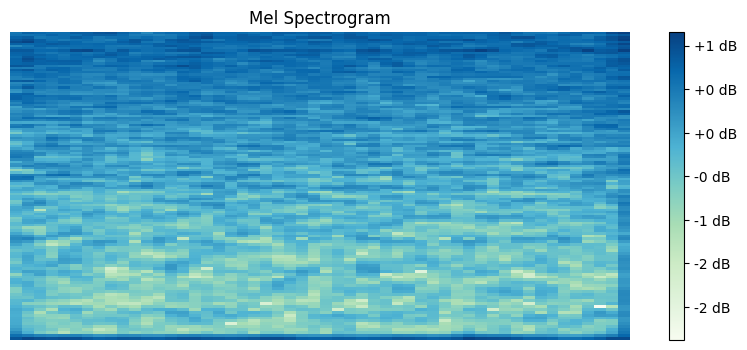

In [10]:
image = np.load(train_list[0])
plt.figure(figsize=(10, 4))
librosa.display.specshow(image, y_axis='mel', x_axis='time', cmap='GnBu')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.axis('off')
plt.show()


In [11]:
image.shape

(128, 52)

In [12]:
batch = tf.expand_dims(image, axis=0)
patches = PatchExtractor()(batch)
patches.shape

TensorShape([1, 48, 256])

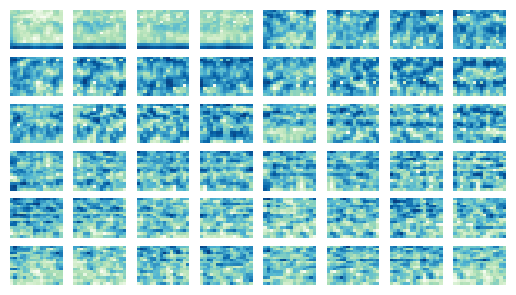

In [13]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n+2, n+2, i + 1)
    patch_img = tf.reshape(patch, (16, 16))
    librosa.display.specshow(patch_img.numpy(), y_axis='mel', x_axis='time' , cmap='GnBu')
    ax.axis("off")

In [50]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=48, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded


In [51]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 49, 768])

In [52]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features, activation=tf.nn.gelu)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [53]:
class Linear(Layer):
  def __init__(self, num_classes):
        super(Linear, self).__init__()
        self.dense1 = Dense(num_classes, activation = tf.nn.softmax)

  def call(self, x):
      x = self.dense1(x)
      return x

In [54]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=12, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = Add()([x3, x2])
        return y

In [55]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=12, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [57]:
transformer = TransformerEncoder(768)
y = transformer(embeddings)
y.shape

TensorShape([1, 49, 768])

In [58]:
def create_VisionTransformer(num_classes, num_patches=48, projection_dim=768, input_shape=(128, 52)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Linear(num_classes)(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model

In [59]:
model = create_VisionTransformer(5)

In [60]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 52)]         0         
                                                                 
 patch_extractor_8 (PatchEx  (None, None, 256)         0         
 tractor)                                                        
                                                                 
 patch_encoder_9 (PatchEnco  (None, 49, 768)           235776    
 der)                                                            
                                                                 
 transformer_encoder_10 (Tr  (None, 49, 768)           368457216 
 ansformerEncoder)                                               
                                                                 
 global_average_pooling1d_7  (None, 768)               0         
  (GlobalAveragePooling1D)                                 

In [ ]:
optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate ,weight_decay=weight_decay
    )

model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.Recall(name="Recall"),
            keras.metrics.Precision(name="Precision")
        ],
    )



history = model.fit(
        train_dataset,
        validation_data = valid_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
    )

In [ ]:
pred = model.evaluate(test_dataset)